In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from Utils import seed, get_train_dataloader, get_test_dataloader, model_to_log, split_x_train, load_data_phase

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

seed(2)

In [2]:
def double_conv_block(in_channels: int, out_channels: int, kernel_size):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=0),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=0),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


def get_model(input_dim, output_dim):
    conv_part = nn.Sequential(
        double_conv_block(input_dim[0], 16, 3),
        double_conv_block(16, 32, 3),
        double_conv_block(32, 64, 3),
        nn.Flatten())

    x = torch.unsqueeze(torch.zeros(input_dim), 0)
    size = conv_part.forward(x).size()[1]
    print('Flatten size:', size)

    model = nn.Sequential(
        conv_part,
        nn.Linear(size, 256),
        # nn.Dropout(p=0.01),
        nn.ReLU(),
        nn.Linear(256, 64),
        # nn.Dropout(p=0.01),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    )

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(pytorch_total_params)

    model.to(device)
    return model

In [3]:
def load_model(file, input_dim, output_dim):
    model = get_model(input_dim, output_dim)
    model.load_state_dict(torch.load(file)['model_state_dict'])
    model.eval()
    return model

In [4]:
def train_epoch(model, loss, optimizer, dataloader, do_train):
    running_loss = 0.

    # Iterate over data.
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        # forward and backward
        with torch.set_grad_enabled(do_train):
            preds = model(inputs)
            loss_value = loss(preds, targets)

            # backward + optimize only if in training phase
            if do_train:
                loss_value.backward()
                optimizer.step()

        # statistics
        running_loss += loss_value.item()

    epoch_loss = running_loss / len(dataloader)

    return epoch_loss


def train_model(model, loss, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, config):
    best_val_loss = math.inf
    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()  # Set model to evaluate mode

            epoch_loss = train_epoch(model, loss, optimizer, dataloader, phase == 'train')

            if phase == 'train':
                scheduler.step()

            if phase == 'val' and best_val_loss > epoch_loss:
                print('new best val loss', epoch_loss, 'epoch', epoch)
                best_val_loss = epoch_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': epoch_loss,
                    'model_name': config['exp_name']
                }, f'{config["exp_name"]}.pth')

    return model

In [5]:
lr = 1e-3
epochs = 200
batch_size = 16
step_size = 20
gamma = 0.99
params = ['V', 'D', 'tp', 'tb']  # 'V', 'D', 'tp', 'tb'

phase_size = (64, 64)

config = {
    "lr": lr,
    "epochs": epochs,
    "bs": batch_size,
    "sched": 'StepLR',
    "sched_ss": step_size,
    "sched_g": gamma,
    "optim": 'Adam',
    "pref": 'forward',
}
important_keys = ['optim', 'bs', 'pref']
config['exp_name'] = '_'.join(map(lambda key: f'{key}={config[key]}', important_keys))
model_file_name = config['exp_name']

In [6]:
x_train, y_train = load_data_phase('Data/DataField4', params, phase_size)
mean = y_train.mean(axis=0)
dispersion = ((y_train - mean) ** 2).mean(axis=0)
y_train = (y_train - mean) / np.sqrt(dispersion)

In [7]:
def norm(array):
    return (array - mean) / np.sqrt(dispersion)


def denorm(array):
    return array * np.sqrt(dispersion) + mean

In [8]:
x_test, y_test = load_data_phase('Data/TestCube', params, phase_size)
y_test = norm(y_test)
x_test, y_test = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), (x_test, y_test))

In [9]:
x_train, y_train, x_val, y_val = map(lambda x: torch.tensor(x, dtype=torch.float, device=device), split_x_train(x_train, y_train, 64))


train_dataloader = get_train_dataloader(x_train, y_train, batch_size)
test_dataloader = get_test_dataloader(x_val, y_val, batch_size)

val files [  2   7  20  24  25  28  32  53  55  67  69  70  77  84 100 109 129 142
 151 160 163 165 174 175 182 190 198 199 200 203 204 209 216 226 228 243
 256 259 265 276 278 284 286 297 307 315 317 327 329 334 335 342 347 348
 349 350 352 367 369 371 376 379 385 401]


In [10]:
model = get_model(x_train.size()[1:], len(params))

config['model'] = model_to_log(model)

loss_func = torch.nn.L1Loss()
# loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Flatten size: 1024
351556


In [11]:
model = train_model(model, loss_func, optimizer, scheduler, train_dataloader, test_dataloader, epochs, config)

new best val loss 0.6835886836051941 epoch 0
new best val loss 0.4959895759820938 epoch 1
new best val loss 0.41206133365631104 epoch 2
new best val loss 0.40485386550426483 epoch 4
new best val loss 0.37529339641332626 epoch 7
new best val loss 0.3588077425956726 epoch 9
new best val loss 0.35236386954784393 epoch 12
new best val loss 0.34099987149238586 epoch 15
new best val loss 0.33368709683418274 epoch 16
new best val loss 0.3230624198913574 epoch 20
new best val loss 0.30801068991422653 epoch 27
new best val loss 0.29919804632663727 epoch 47
new best val loss 0.2811327502131462 epoch 52
new best val loss 0.2809319794178009 epoch 88
new best val loss 0.2805033475160599 epoch 95
new best val loss 0.2798447236418724 epoch 96
new best val loss 0.2754417508840561 epoch 98
new best val loss 0.2690840810537338 epoch 100
new best val loss 0.2674141824245453 epoch 103
new best val loss 0.2613758146762848 epoch 127
new best val loss 0.2611212432384491 epoch 170


In [12]:
best_model = load_model(f'{config["exp_name"]}.pth', x_train[0].size(), len(params))

Flatten size: 1024
351556


In [13]:
y_val_result = best_model.forward(x_val).detach()
y_train_result = best_model.forward(x_train).detach()
y_test_result = best_model.forward(x_test).detach()

In [14]:
y_val_result_np = y_val_result.cpu().numpy()
y_train_result_np = y_train_result.cpu().numpy()
y_test_result_np = y_test_result.detach().cpu().numpy()

y_val_np = y_val.detach().cpu().numpy()
y_train_np = y_train.detach().cpu().numpy()
y_test_np = y_test.detach().cpu().numpy()

In [15]:
def add_subplot(fig, train, result, param_index, plot_index, label):
    
    sort = train[:, param_index].argsort(axis=0).reshape((-1,))
    ax_train = fig.add_subplot(3, 1, plot_index)
    ax_train.set_title(label=label, fontsize=12)
    ax_train.set_ylabel(param)
    ax_train.set_xlabel('num File')
    ax_train.plot(denorm(train[sort])[:, param_index], 'go', label='train')
    ax_train.plot(denorm(result[sort])[:, param_index], 'ro', label='result')
    ax_train.legend()
    
def show(param_index, param):

    fig = plt.figure(figsize=(12, 12))
    fig.suptitle(f'Параметр {param}', fontsize=16)

    fig.subplots_adjust(hspace=0.4)
    
    add_subplot(fig, y_train_np, y_train_result_np, param_index, 1, 'Обучающий набор')
    add_subplot(fig, y_val_np, y_val_result_np, param_index, 2, 'Валидационный набор')
    add_subplot(fig, y_test_np, y_test_result_np, param_index, 3, 'Тестовый набор')

    plt.show()

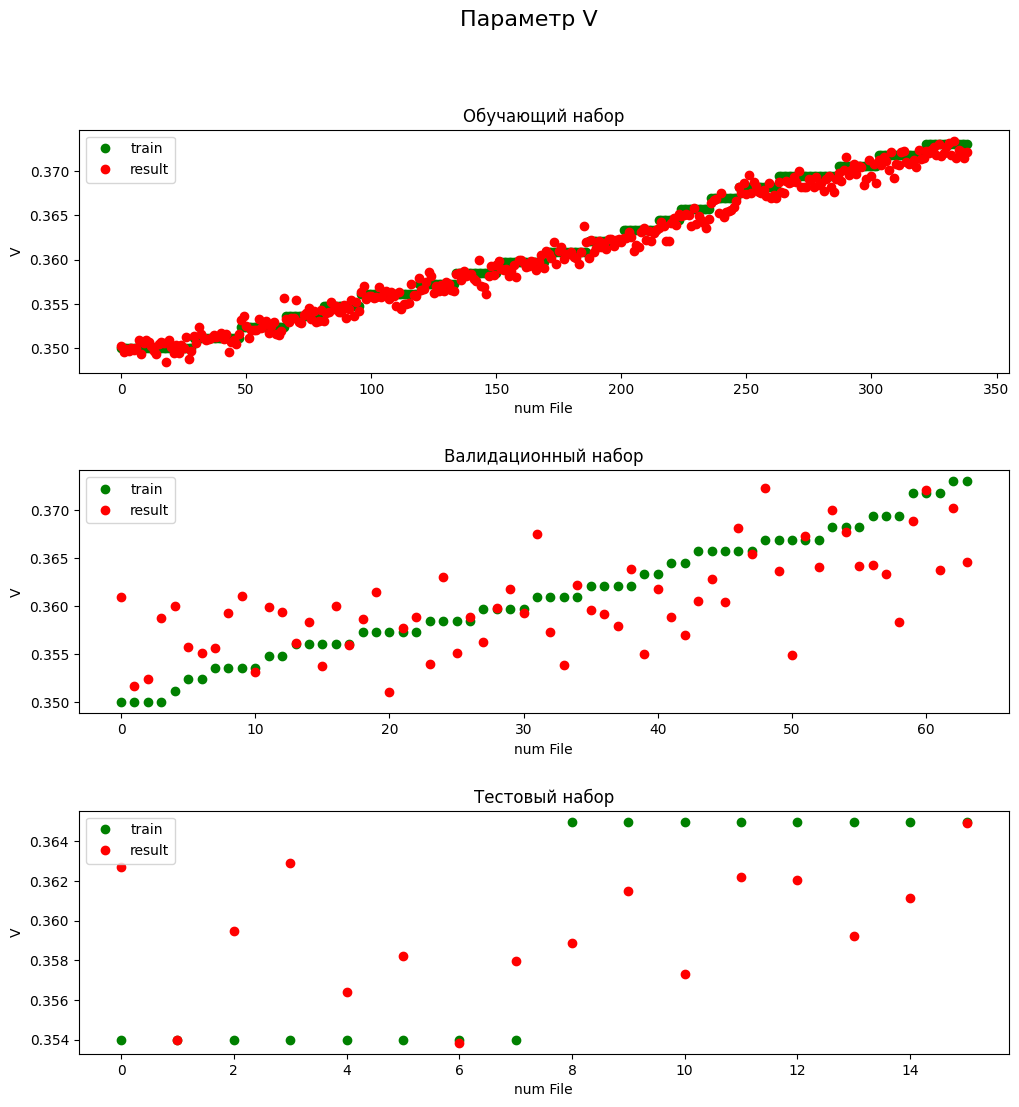

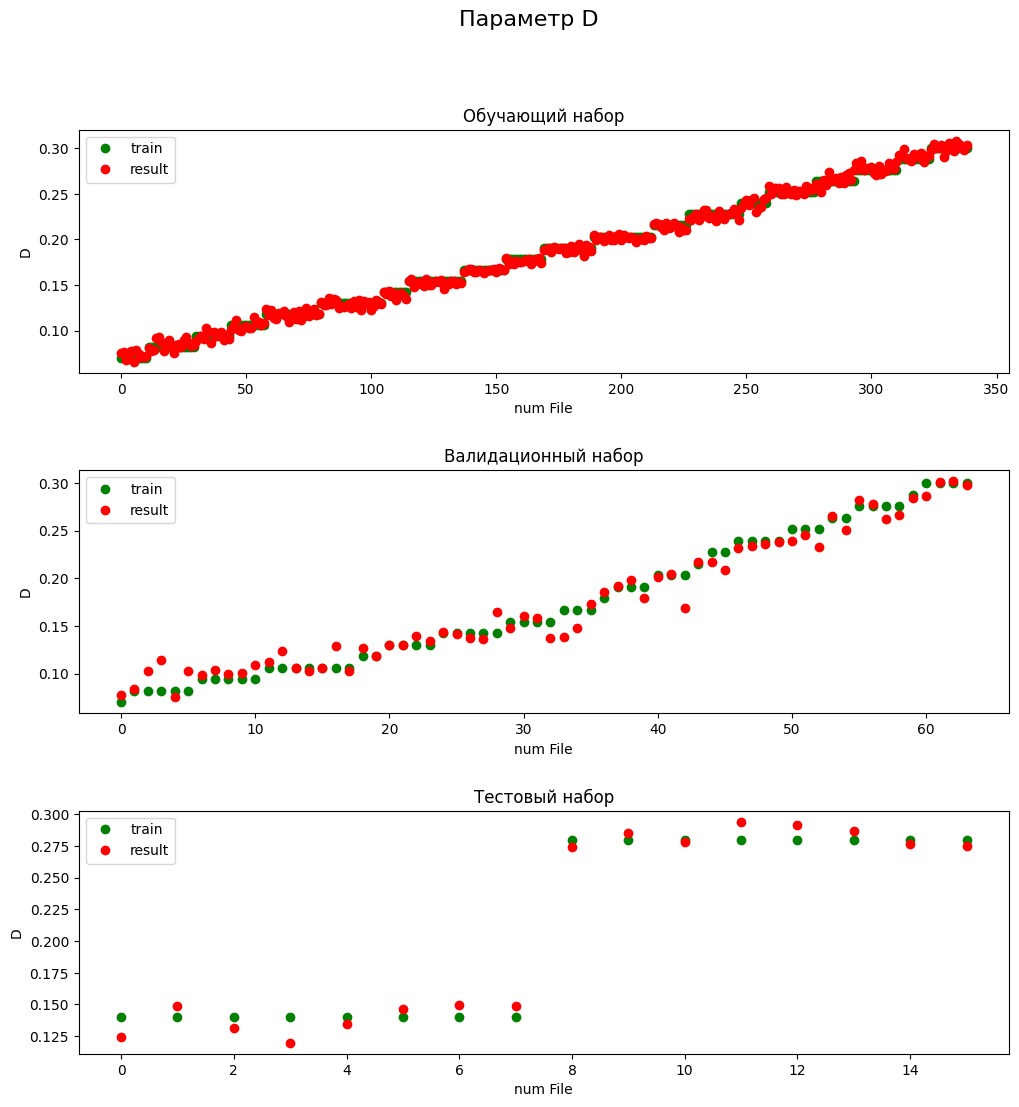

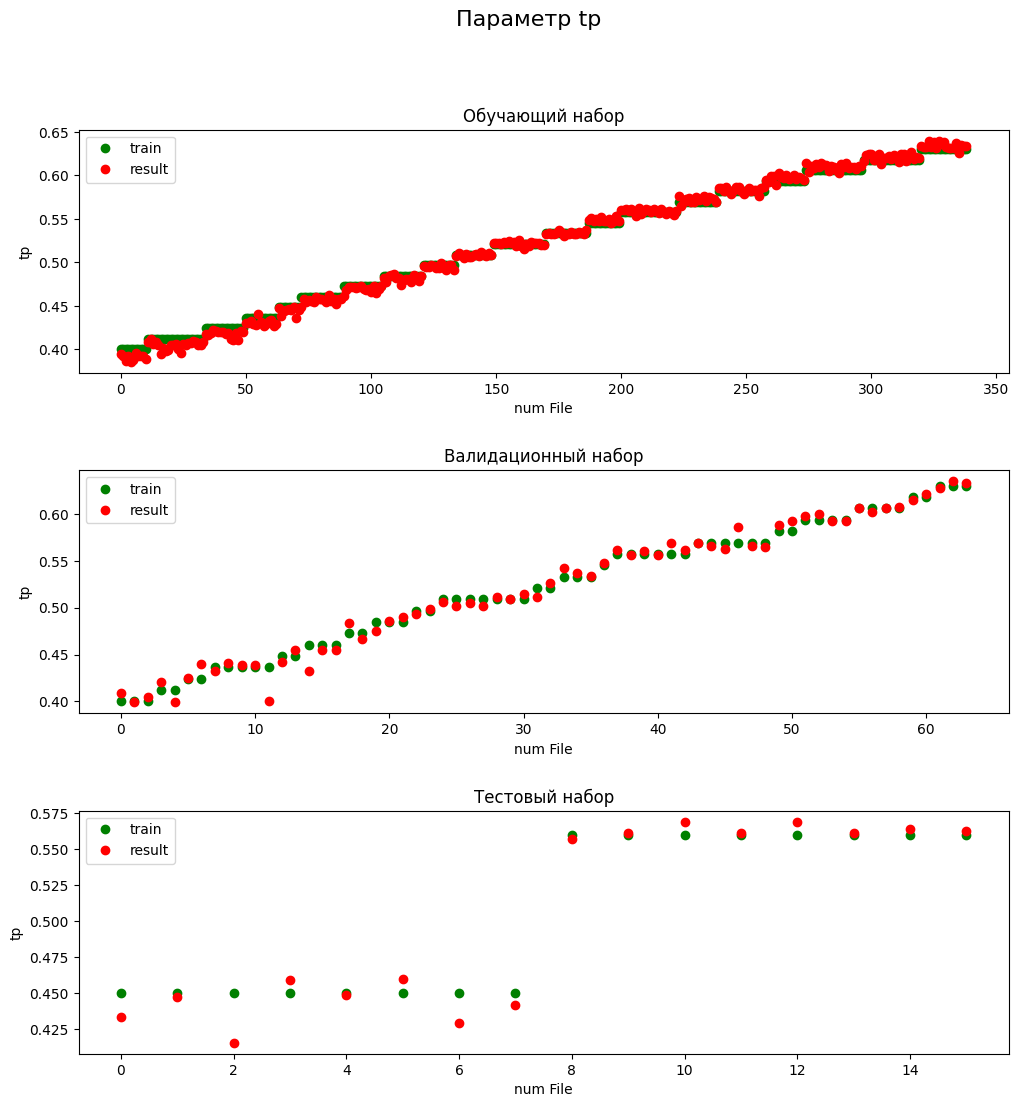

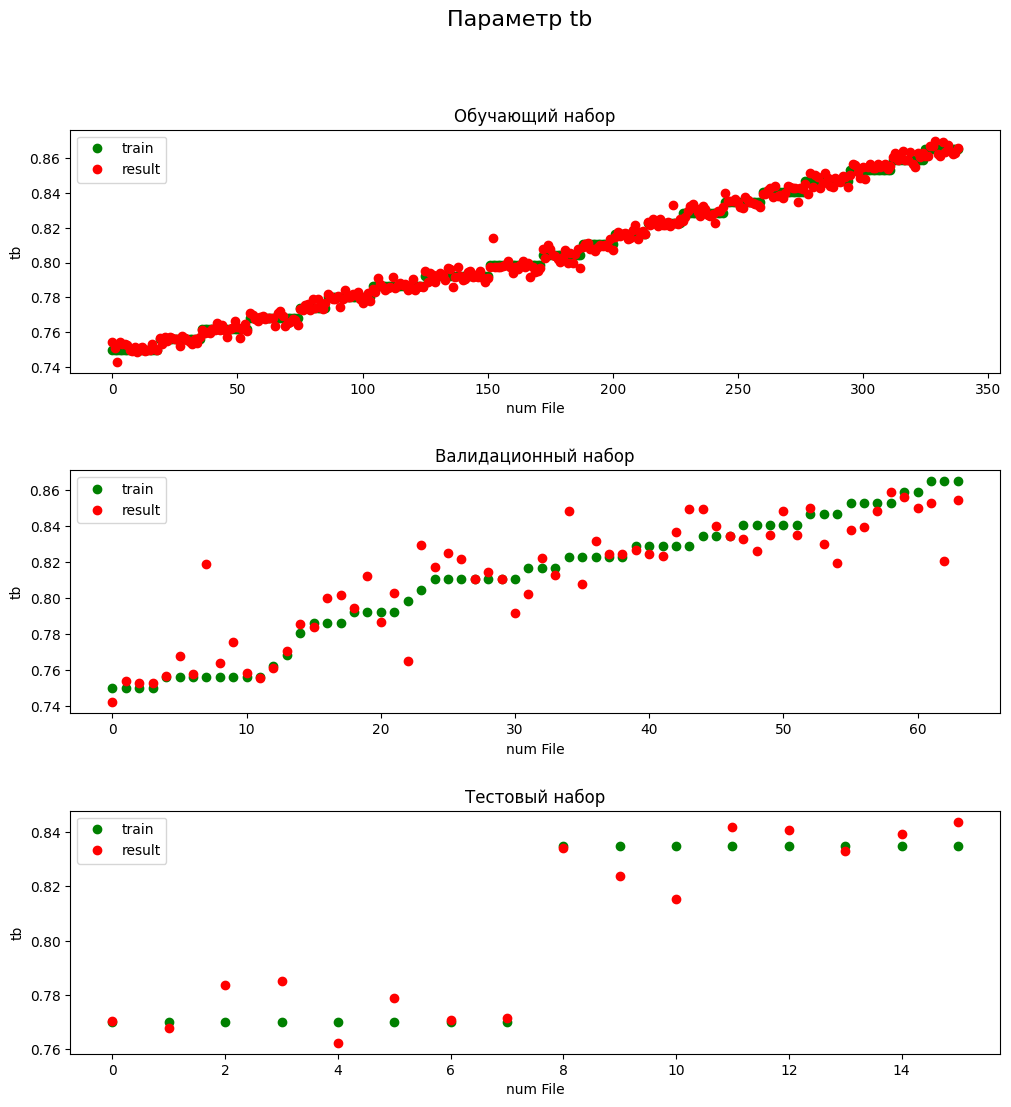

In [16]:
for param_index, param in enumerate(params):
    show(param_index, param)

In [17]:
def get_loss(result, real, i):
    error_m = torch.nn.MSELoss()(result[:, i], real[:, i]).item()
    error_a = torch.nn.L1Loss()(result[:, i], real[:, i]).item()
    return round(error_m, 6), round(error_a, 6)

def print_errors(i):
    train_error_m, train_error_a = get_loss(y_train_result, y_train, i)
    print('train error L1', train_error_a, 'MSE', train_error_m)
    val_error_m, val_error_a = get_loss(y_test_result, y_test, i)
    print('val error L1', val_error_a, 'MSE', val_error_m)
    test_error_m, test_error_a = get_loss(y_val_result, y_val, i)
    print('test error L1', test_error_a, 'MSE', test_error_m)

In [18]:
for param_index, param in enumerate(params):
    print(param, 'errors')
    print_errors(param_index)

V errors
train error L1 0.098304 MSE 0.015817
val error L1 0.576235 MSE 0.47683
test error L1 0.538799 MSE 0.453728
D errors
train error L1 0.049752 MSE 0.003861
val error L1 0.1253 MSE 0.020506
test error L1 0.126548 MSE 0.030013
tp errors
train error L1 0.055034 MSE 0.004954
val error L1 0.120451 MSE 0.029955
test error L1 0.081966 MSE 0.014021
tb errors
train error L1 0.062003 MSE 0.006479
val error L1 0.197389 MSE 0.065539
test error L1 0.297172 MSE 0.186406
